<a href="https://colab.research.google.com/github/preetamjumech/blood_cell_classification_cnn/blob/main/Preetam_Saha_28_09_2022_CNN_Blood_Cell_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR']="/content/drive/MyDrive/kaggle"

In [2]:
!kaggle datasets list -s "blood cell classification"

ref                                                          title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
colearninglounge/chronic-kidney-disease                      Chronic Kidney Disease                             10KB  2020-08-26 03:33:35           2795         41  0.8235294        
mansoordaku/ckdisease                                        Chronic KIdney Disease dataset                     10KB  2017-04-13 09:16:08          18277        187  0.7058824        
andrewmvd/leukemia-classification                            Leukemia Classification                           867MB  2020-08-29 11:40:51           4711        132  0.875            
kmader/malaria-bounding-boxes                                Malaria Bounding Boxes  

In [5]:
!kaggle datasets download -d "paultimothymooney/blood-cells"

 87% 94.0M/108M [00:00<00:00, 169MB/s]
100% 108M/108M [00:00<00:00, 166MB/s] 


In [ ]:
!unzip "/content/blood-cells.zip"

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)

In [8]:
from PIL import Image

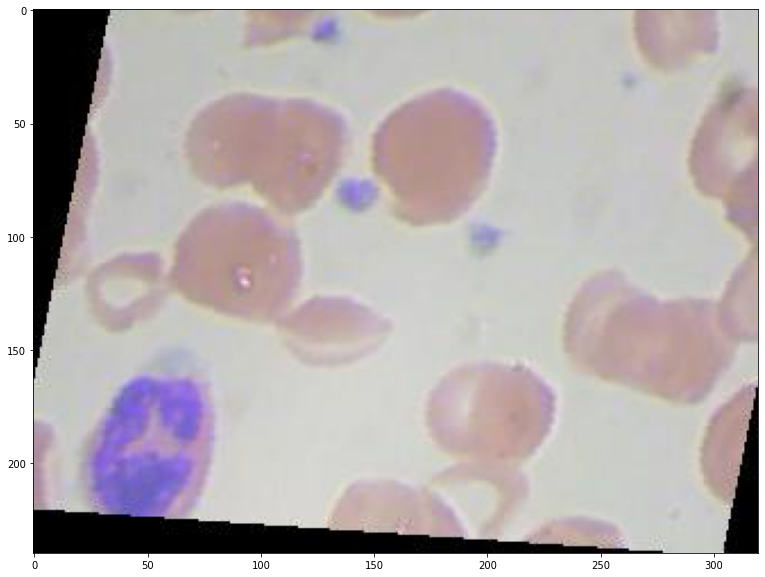

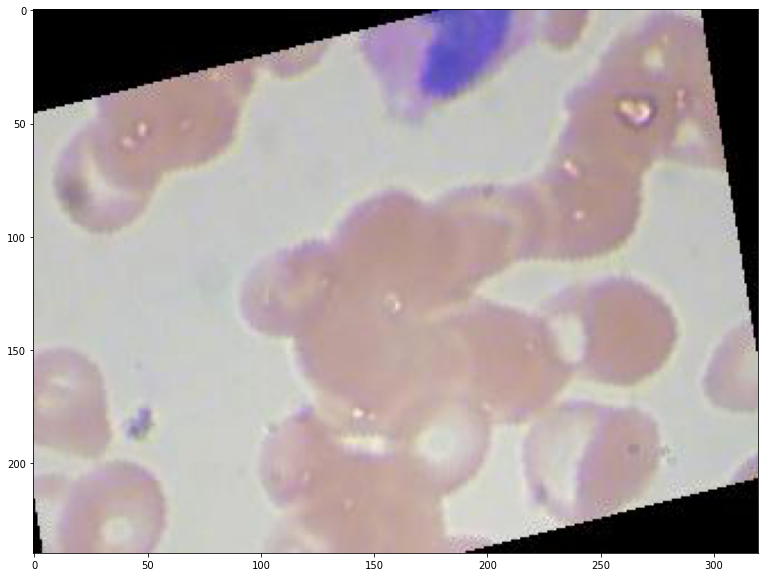

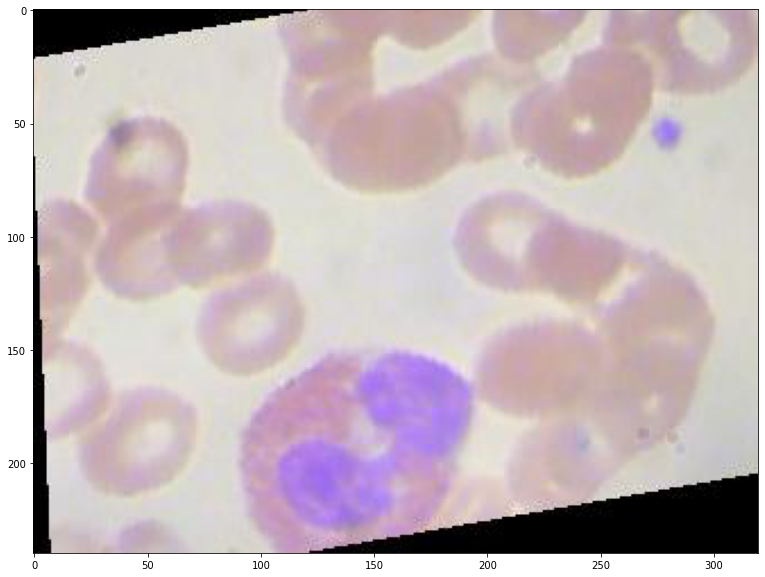

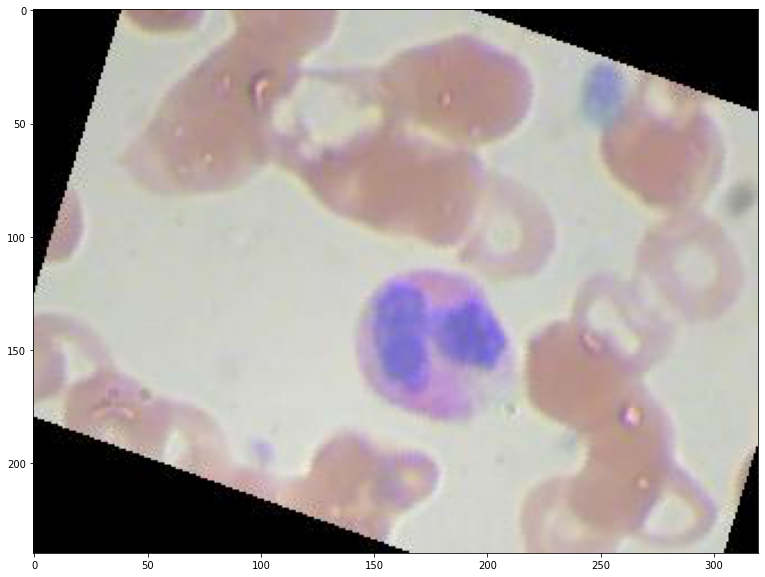

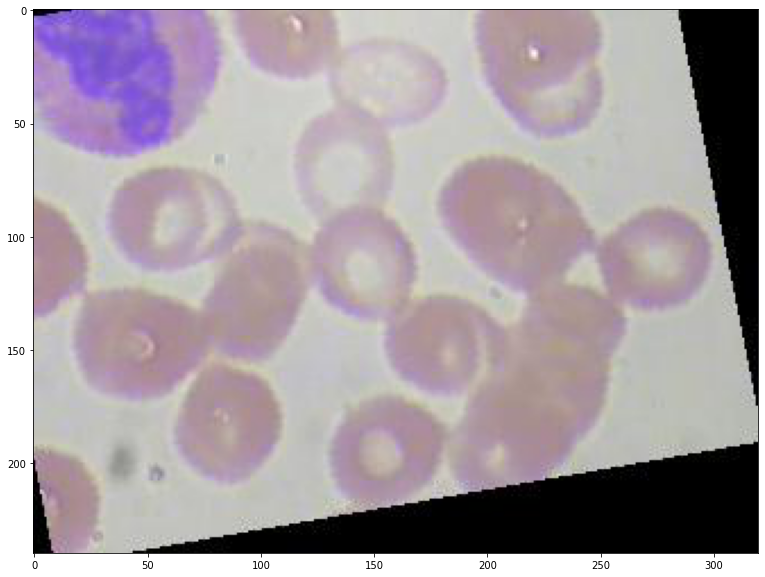

In [9]:
for i in os.listdir("/content/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL")[20:25]:
  plt.figure()
  a=Image.open(f"/content/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/{i}")
  plt.imshow(a)

In [10]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

In [11]:
transf = transforms.Compose([transforms.PILToTensor(), 
                             transforms.Resize(size=(256,256)),
                             transforms.RandomHorizontalFlip(),
                             transforms.RandomVerticalFlip()])

In [13]:
train_loader = DataLoader(ImageFolder("/content/dataset2-master/dataset2-master/images/TRAIN",transform = transf),batch_size=32,shuffle=True)

In [14]:
val_loader = DataLoader(ImageFolder("/content/dataset2-master/dataset2-master/images/TEST",transform = transf),batch_size=128,shuffle=False)

In [15]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam

In [17]:
class blood_cnn(nn.Module):
  def __init__(self):
    super(blood_cnn,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,padding=1) #in_channels=RGB(3),out_channels=no of filters
    self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1) #kernel_size=3, padding =1 ,same size
    self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
    self.conv4 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
    self.conv5 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
    self.bn2 = nn.BatchNorm2d(num_features=16) #for 2
    self.bn3 = nn.BatchNorm2d(num_features=32)
    self.bn4 = nn.BatchNorm2d(num_features=64)
    self.drop = nn.Dropout() #dont have parametrs to be learned. so defining only once
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2) #dont have parametrs to be learned. so defining only once
    self.fc1 = nn.Linear(in_features=8*8*256,out_features=512)
    self.fc2 = nn.Linear(in_features=512,out_features=64)
    self.fc3 = nn.Linear(in_features=64,out_features=4)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.pool(x) #size = 128

    x = self.bn2(x) #batchnormalization, conv, pooling
    x= F.relu(self.conv2(x))
    x = self.pool(x) #size = 64
 
    x = self.bn3(x)
    x = F.relu(self.conv3(x))
    x = self.pool(x) #size = 32

    x = self.bn4(x)
    x = F.relu(self.conv4(x))
    x = self.pool(x) #size = 16
    x = self.drop(x) 
    
    x = F.relu(self.conv5(x))
    x = self.pool(x) #size = 8

    x = x.view(x.size()[0],-1)
    x = F.relu(self.fc1(x))
    x = self.drop(x)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    
    return x

In [18]:
model = blood_cnn()

In [19]:
opt = Adam(model.parameters(), lr=0.0001)

In [20]:
import torchsummary

In [21]:
torchsummary.summary(model, input_size=(3,256,256),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
         MaxPool2d-2         [-1, 16, 128, 128]               0
       BatchNorm2d-3         [-1, 16, 128, 128]              32
            Conv2d-4         [-1, 32, 128, 128]           4,640
         MaxPool2d-5           [-1, 32, 64, 64]               0
       BatchNorm2d-6           [-1, 32, 64, 64]              64
            Conv2d-7           [-1, 64, 64, 64]          18,496
         MaxPool2d-8           [-1, 64, 32, 32]               0
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10          [-1, 128, 32, 32]          73,856
        MaxPool2d-11          [-1, 128, 16, 16]               0
          Dropout-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         295,168
        MaxPool2d-14            [-1, 25

In [22]:
from tqdm import tqdm

In [24]:
def training(model, train_loader, opt):
    train_loss = 0.0
    model.train()
    for batch, target in tqdm(train_loader):
        batch = batch.float().to('cuda')
        target = target.to('cuda')

        opt.zero_grad()
        output = model(batch.float())
        loss = F.cross_entropy(output, target)
        loss.backward()
        opt.step()
        train_loss += loss.item()

    return train_loss

In [25]:
def validate(model, val_loader, opt):
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for batch, target in tqdm(val_loader):
            batch = batch.float().to('cuda')
            target = target.to('cuda')

            output = model(batch.float())
            loss = F.cross_entropy(output, target)
            val_loss += loss.item()
    return val_loss

In [26]:
model = model.to('cuda')
hist = {'train_loss':[], 'val_loss':[]}
for epoch in range(1):
    hist['train_loss'].append(training(model, train_loader,opt))
    hist['val_loss'].append(validate(model, val_loader,opt))

100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


In [27]:
hist["train_loss"][-1], hist["val_loss"][-1]

(387.9503510594368, 20.06109419465065)

In [28]:
from sklearn.metrics import accuracy_score

In [29]:
test_loader = DataLoader(ImageFolder("/content/dataset2-master/dataset2-master/images/TEST",transform = transf),batch_size=512,shuffle=False)

In [30]:
def validate_accuracy1(model, val_loader, opt):
    model.eval()
    with torch.no_grad():
      acc=[]
      for batch, target in tqdm(val_loader):
        batch = batch.float().to('cuda')
        target = target.to('cuda')
        output = model(batch)
        preds=np.argmax(output.detach().cpu().numpy(),axis=1)
        acc.append(accuracy_score(target.detach().cpu(),preds))
    
    return(acc)

In [31]:
validate_accuracy1(model,test_loader,opt)

100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


[0.24609375, 0.84375, 0.84375, 0.599609375, 0.34851936218678814]

In [32]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,accuracy_score

In [34]:
def validate_accuracy2(model, val_loader, opt):
    model.eval()
    with torch.no_grad():
      for batch, target in tqdm(val_loader):
        batch = batch.float().to('cuda')
        target = target.to('cuda')
        output = model(batch)
        preds=np.argmax(output.detach().cpu().numpy(),axis=1)
        y_test=target.detach().cpu()
        cm=confusion_matrix(y_test,preds)
        disp=ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()

100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


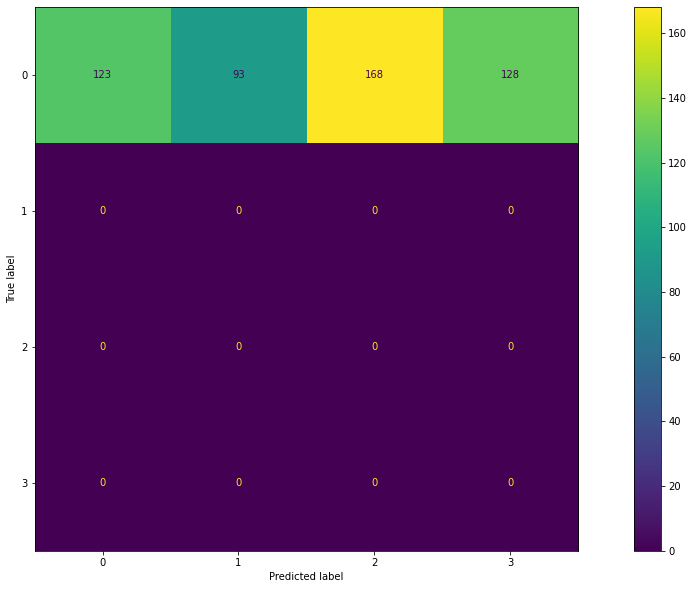

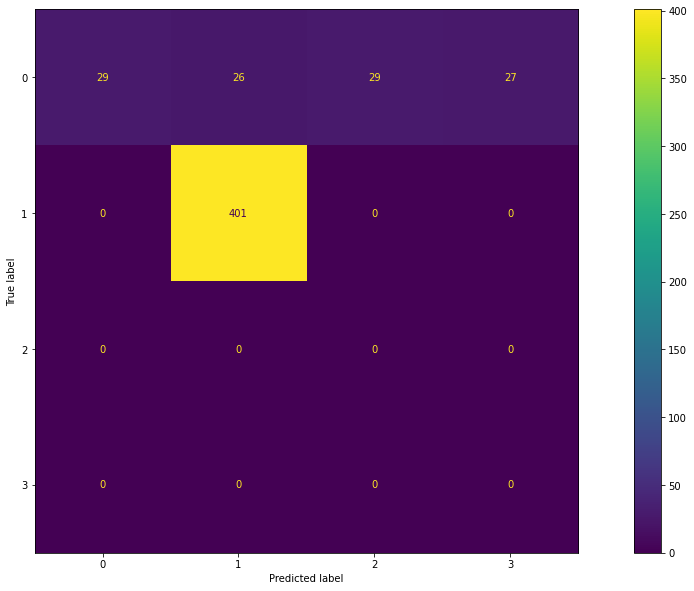

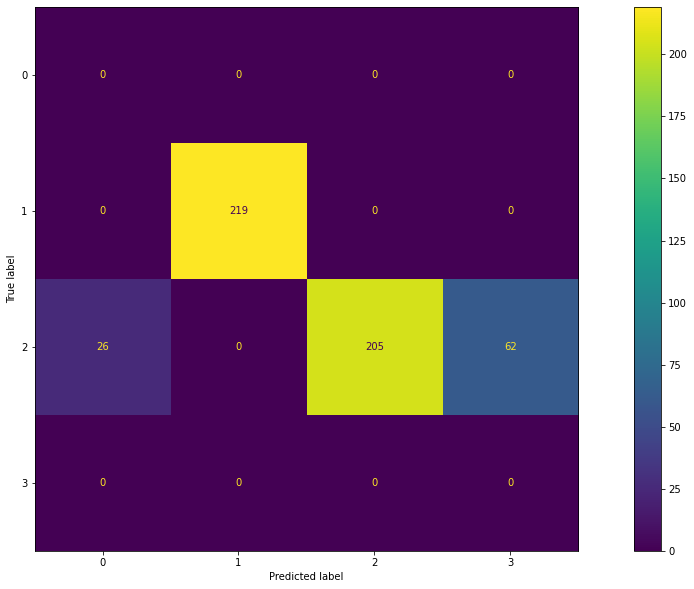

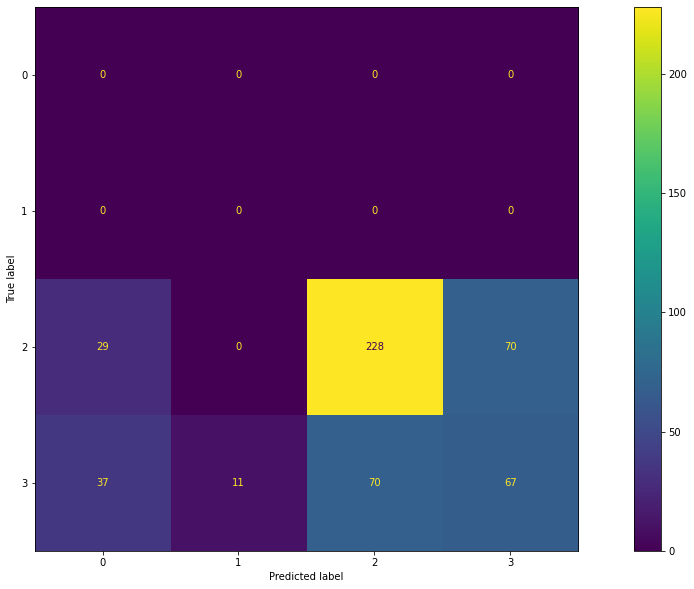

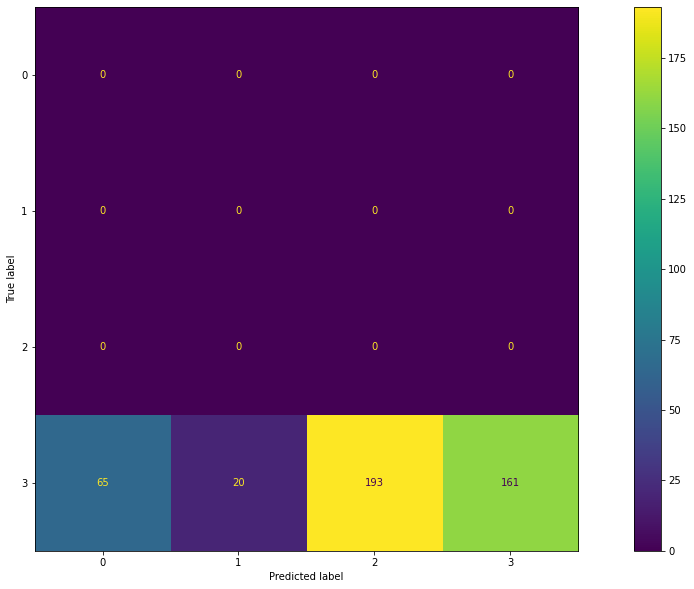

In [35]:
validate_accuracy2(model,test_loader,opt)